In [1]:
# Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from env import host, user, password
import os

# Block Warning Boxes
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid blue"> </hr>

# Acquire

For now I am only going to acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the zillow database for all 'Single Family Residential' properties. This should allow me to get my MVP.


In [2]:
def get_connection(database_name):
    '''
    This function takes in a string representing a database name for the Codeup mySQL server 
    and returns a string that can be used to open a connection to the server.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database_name}'


In [3]:
def get_zillow_data():
    '''
    This function reads the Zillow database from the Codeup mySQL server and  returns a dataframe.
    If a local file does not exist, this function writes data to a csv file as a backup. The local file 
    ensures that data can be accessed, in the event that you cannot talk to the mySQL database. 
    '''
    # The filename will have 2017 at the end to represent that the only data being looked at is 
    # properties from the year 2017
    if os.path.isfile('zillow2017.csv'):
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from database into a DataFrame
        # property land use type id is limited to 'Single Family Residential' properties.
        df =  pd.read_sql(""" SELECT bedroomcnt, 
                                     bathroomcnt, 
                                     calculatedfinishedsquarefeet, 
                                     yearbuilt, 
                                     regionidzip, 
                                     fips,
                                     taxvaluedollarcnt
                              FROM properties_2017
                              JOIN predictions_2017 USING (parcelid)
                              WHERE propertylandusetypeid = 261;""", 
                            get_connection('zillow')
                        )
        # Cache data into a csv backup
        df.to_csv('zillow2017.csv')
    
    # Renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'squarefeet',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})   
    return df

I noticed there is an 'Inferred Family Housing' properties type. Upon inspection, I decided not to add this to my dataframe because it only contained a single row with nulss.

In [4]:
zillow = get_zillow_data()
zillow.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0


In [5]:
zillow.shape

(52442, 7)

In [6]:
zillow.describe()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
count,52442.000000,52442.000000,52360.000000,52326.000000,52416.000000,52442.000000,5.244100e+04
mean,3.300675,2.299397,1922.874083,1963.393820,96635.843559,6049.131917,5.296830e+05
std,0.949086,1.022764,1004.363491,23.133355,4605.063649,21.028933,7.518883e+05
min,0.000000,0.000000,128.000000,1878.000000,95982.000000,6037.000000,1.000000e+03
25%,3.000000,2.000000,1268.000000,1950.000000,96206.000000,6037.000000,1.937500e+05
50%,3.000000,2.000000,1659.000000,1961.000000,96412.000000,6037.000000,3.736120e+05
75%,4.000000,3.000000,2306.000000,1979.000000,96995.000000,6059.000000,6.193010e+05
max,14.000000,18.000000,21929.000000,2016.000000,399675.000000,6111.000000,4.906124e+07


<hr style="border:2px solid blue"> </hr>

# Prepare

In [7]:
# This dataset is a bit larger, so I will need to set verbose and null_counts to true
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52442 non-null  float64
 1   bathrooms    52442 non-null  float64
 2   squarefeet   52360 non-null  float64
 3   year_built   52326 non-null  float64
 4   regionidzip  52416 non-null  float64
 5   fips         52442 non-null  float64
 6   tax_value    52441 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [8]:
# I can see I have some null values, let's see how many in each column:
zillow.isnull().sum()

bedrooms         0
bathrooms        0
squarefeet      82
year_built     116
regionidzip     26
fips             0
tax_value        1
dtype: int64

In [9]:
# What percentage of my data is this?
zillow.isnull().sum().sum() / zillow.shape[0]

0.004290454216086343

- If I were to remove all rows with nulls, this would remove less than 1% of my data. 
- I think it would be safe to drop all nulls and not have it affect my future explore and modeling


In [10]:
# Dropping all rows with null values
before = zillow.shape[0]
zillow = zillow.dropna()
print ((before - zillow.shape[0]), 'rows dropped')

141 rows dropped


In [11]:
# Making sure my non-null counts look good
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52301 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52301 non-null  float64
 1   bathrooms    52301 non-null  float64
 2   squarefeet   52301 non-null  float64
 3   year_built   52301 non-null  float64
 4   regionidzip  52301 non-null  float64
 5   fips         52301 non-null  float64
 6   tax_value    52301 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


#### Notes:
Now to take a look at Dtypes for each row.

- I believe Bedrooms are supposed to be whole numbers, so I'll change this row to integers.
- Bathrooms are known to have wierd numbers like 2.5 Bath, so float makes sense here.  
- squarefeet can stay a float 
- I should probably change yearbuilt to an integer
- regionidzip is zipcodes, which we know are integers.  
  
- Also, I googled fips because I didn't know what it was:  
    - Federal Information Processing System (FIPS) Codes for States and Counties. 
    - FIPS codes are numbers which uniquely identify geographic areas.  
  
- It looks like fips are whole numbers, so I'll make that an integer too!   
- tax_value is money, so a float works just fine here


In [12]:
# Just to be sure, I'm going to check and see if any of the bedroom counts utilize this decimal
zillow.bedrooms[(zillow.bedrooms % 1) != 0]

Series([], Name: bedrooms, dtype: float64)

Nope! Looks like I'm okay to change bedrooms into integers.

In [13]:
zillow["regionidzip"] = zillow.regionidzip.astype(int)
zillow["bedrooms"] = zillow.bedrooms.astype(int)
zillow["year_built"] = zillow.year_built.astype(int)
zillow["fips"] = zillow.fips.astype(int)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52301 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52301 non-null  int64  
 1   bathrooms    52301 non-null  float64
 2   squarefeet   52301 non-null  float64
 3   year_built   52301 non-null  int64  
 4   regionidzip  52301 non-null  int64  
 5   fips         52301 non-null  int64  
 6   tax_value    52301 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.2 MB


In [14]:
# I noticed some rows with zero bedrooms. Are there some nulls in my data disguised as zeros?
zillow[(zillow.bathrooms == 0) | (zillow.bedrooms == 0) | (zillow.squarefeet == 0)]

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
590,0,5.0,5782.0,2006,96120,6037,4626995.0
2694,0,0.0,1208.0,1990,95984,6037,185161.0
2899,0,0.0,280.0,1953,96267,6037,963472.0
3261,0,1.0,288.0,1922,96023,6037,67521.0
4675,0,1.0,480.0,1948,96217,6037,227272.0
...,...,...,...,...,...,...,...
51299,0,0.0,984.0,1927,95982,6037,183027.0
51811,0,1.0,1150.0,1930,95995,6037,158000.0
52163,0,0.0,2307.0,1948,96100,6037,499000.0
52175,0,1.0,440.0,1947,96027,6037,1374602.0


#### That's another 73 rows of data with null values. 
Could these zeros represent a vacant lot that hasn't been built yet? It seems that there is a separate category for this in the database called "Vacant Land - General", so probably not.

- ( 73 + 141 )/52442 = 0.408%
- that's still less than 1% of our original data.
- If I drop these 73 rows with zeros plus the 141 rows with nulls, I will still have lost less than 1% of my data which means it shouldn't effect my exploration and modeling. 

In [15]:
before = zillow.shape[0]
zillow = zillow[(zillow.bathrooms != 0) & (zillow.bedrooms != 0) & (zillow.squarefeet != 0)]
print((before - zillow.shape[0]),"rows dropped" )

73 rows dropped


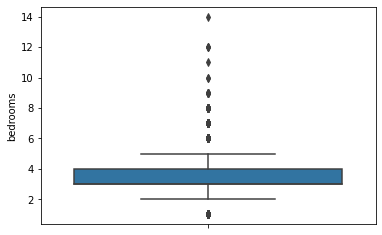

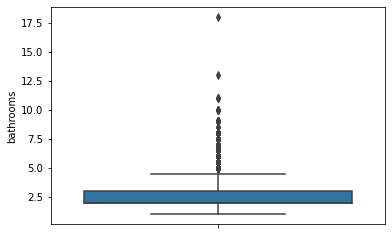

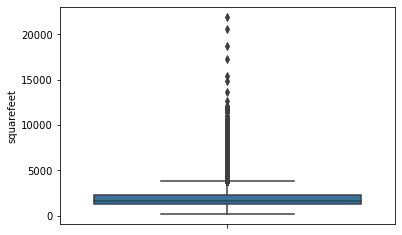

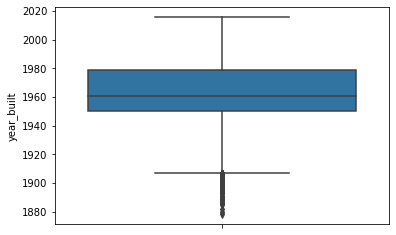

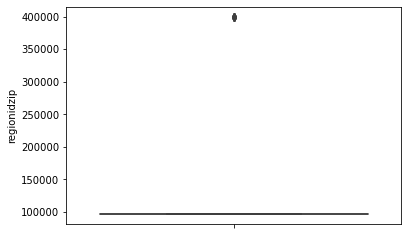

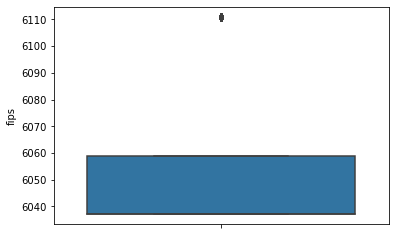

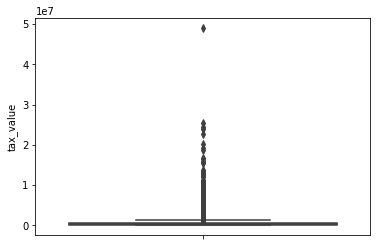

In [16]:
# Next is to look for outliers. I'll start this task by first taking a visual look at my columns. 

columns = zillow.columns

# Create boxplots for each column
for x in columns:
    sns.boxplot(data= zillow, y = x)
    plt.title('')
    plt.show()

- bedrooms: I don't really want a Kim Kardashian house with 14 bedrooms for my model. I believe these houses might be outliers for my Single Family Residential properties. 
- bathrooms: The same can be said for bathrooms.
- squarefeet: I believe taking care of squarefeet might resolve bedrooms and bathrooms
- yearbuilt: I don't see anything worrisome here.
- regionidzip: I'll have to investigate these outliers before removing
- fips: I'll have to investigate these outliers before removing
- tax_value: I'll definitely scale my target to ensure the best model down the line

In [17]:
def remove_outliers(df, k, col_list):
    ''' 
    This dataframe takes in a dataframe, a define k, and the list of columns to be checked for outliers.
    The outliers are removed based on statistical upper and lower bounds, and a dataframe of 
    remaining rows is returned.
    '''

    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # Return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [18]:
before = zillow.shape[0]
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 
                                      'bathrooms', 
                                      'squarefeet', 
                                      #'year_built', 
                                      #'regionidzip',
                                      #'fips', 
                                      'tax_value'])

print((before - zillow.shape[0]), 'rows dropped')

6639 rows dropped


- (6639 + 141 + 73)/52442 = 13.08%
- After removing nulls, zeros, and outliers I have lost approximately 13% of my data. This should still be a low enough number not to affect my exploration and models 

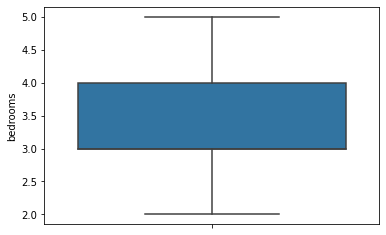

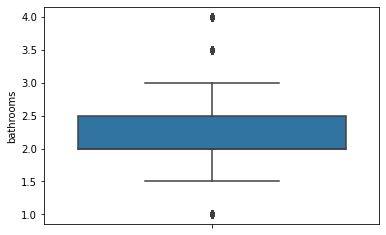

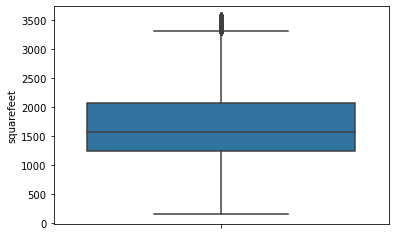

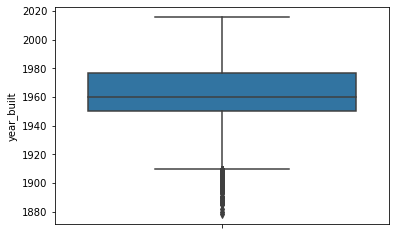

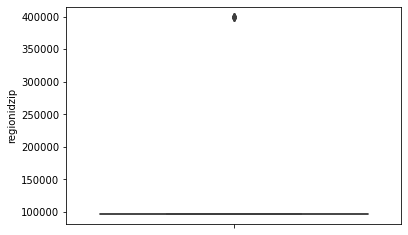

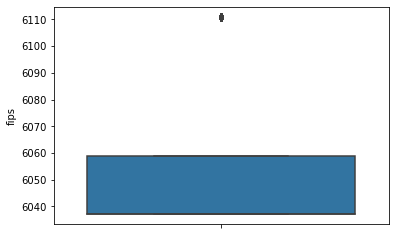

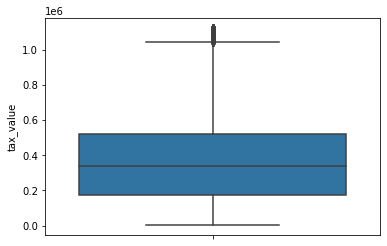

In [19]:
# Let's take another look at our columns after removing the more extreme outliers
for x in zillow.columns:
    sns.boxplot(data= zillow, y = x)
    plt.title('')
    plt.show()

Now that my data is starting to look a lot cleaner, I'm gonna scale it and then I'll be ready to explore!

In [20]:
# First I have to split the data. The scaling has to be fitted, which means I need my Train dataset
# Note: When scaling, fit on train and then apply to validate and test. 

train_validate, test = train_test_split(zillow, test_size=.2, random_state= 42)
train, validate = train_test_split(train_validate, test_size=.3, random_state= 42)

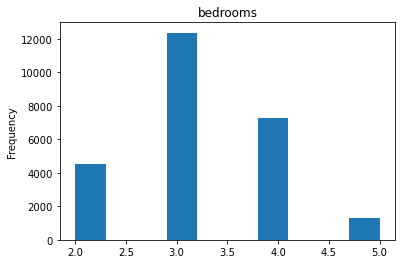

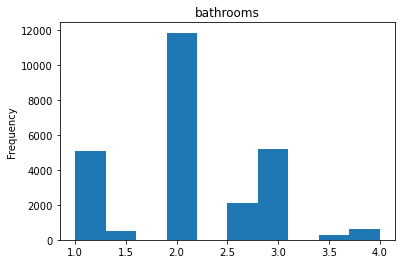

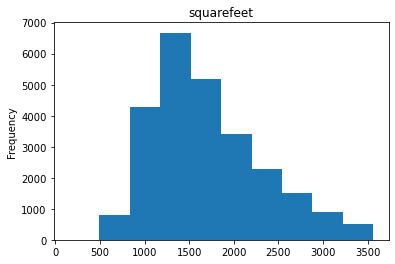

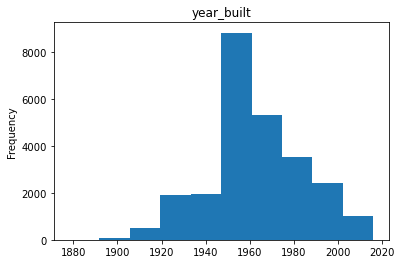

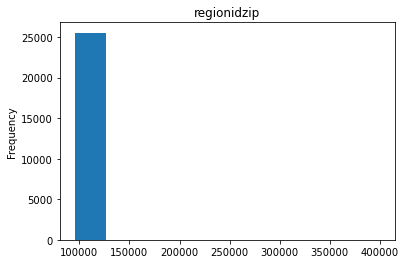

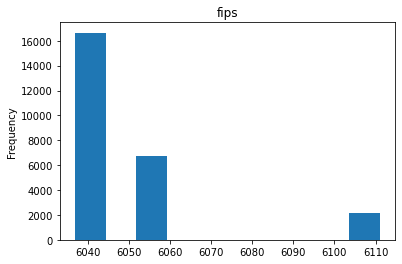

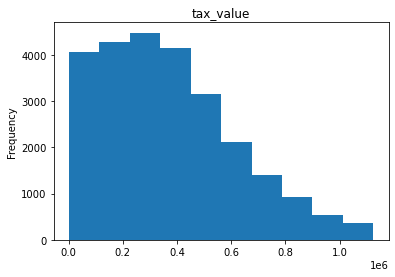

In [21]:
# Let's see what the distributions look like before I start
for x in train.columns: 
    train[ x ].plot.hist(title= x)
    plt.show();

To save some time I will use the function i created in the scaling exercises. I put this zillow dataframe through all the scaler types we learned about and found the Min_Max scaler looked the best. So I will copy that function both here and into my wrangle!

In [22]:
def Min_Max_Scaler(train, validate, test):
    """
    Takes in the pre-split data and uses train to fit the scaler. The scaler is then applied to all dataframes and 
    the dataframes are returned in thier scaled form.
    """
    # 1. Create the object
    scaler = sklearn.preprocessing.MinMaxScaler()

    # 2. Fit the object (learn the min and max value)
    scaler.fit(train[['tax_value', 'squarefeet']])

    # 3. Use the object (use the min, max to do the transformation)
    train[['tax_value', 'squarefeet']] = scaler.transform(train[['tax_value', 'squarefeet']])
    test[['tax_value', 'squarefeet']] = scaler.transform(test[['tax_value', 'squarefeet']])
    validate[['tax_value', 'squarefeet']] = scaler.transform(validate[['tax_value', 'squarefeet']])
    
    return train, validate, test

In [23]:
# Abra-cadabra!
train, validate, test = Min_Max_Scaler(train,validate,test)

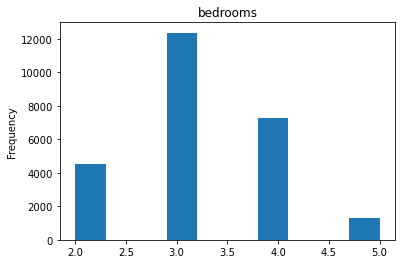

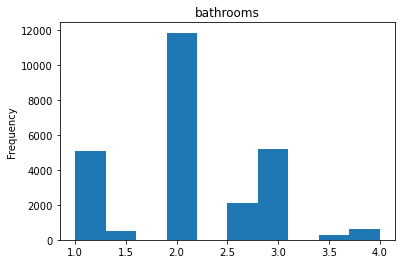

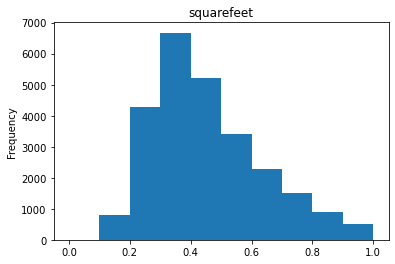

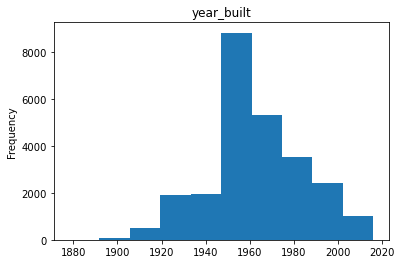

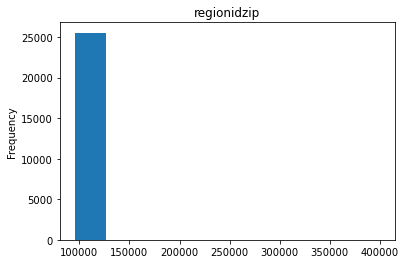

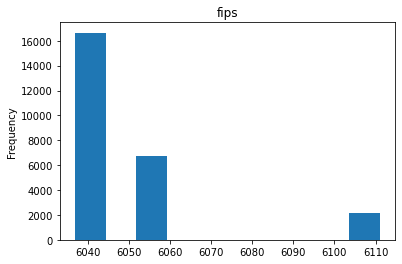

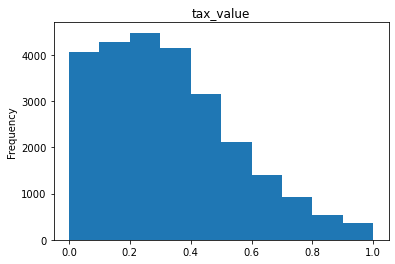

In [24]:
# Let's check how the distributions look with scaling 
for x in train.columns: 
    train[ x ].plot.hist(title= x)
    plt.show();

Looks like that scaling worked nicely! I want to make one more adjustment before exploration though. I've decided I'm going to make a new column based on `year_built`. We'll name it `years_old` so that we can see how old the home is without doing mental math.  

In [25]:
# Notice that since we are working with 2017 data, that I am claculating 
# how old the home was in 2017 and not how old it is today
train['years_old'] = 2017 - train.year_built
validate['years_old'] = 2017 - train.year_built
test['years_old'] = 2017 - train.year_built

train.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,years_old
36317,3,2.0,0.322392,1959,97104,6111,0.046060,58
26167,3,2.0,0.328839,1953,96201,6037,0.049221,64
635,4,2.5,0.596131,1986,97097,6111,0.607301,31
49331,4,3.0,0.588218,1964,97118,6111,0.321354,53
10086,4,2.0,0.351700,1954,96370,6037,0.414059,63


Almost forgot! The prject specs ask me to find the state and county each home is in, since this effects tax_value. 

In [26]:
# I'm going to start by checking how many different fips I have
train.fips.value_counts()

6037    16647
6059     6725
6111     2157
Name: fips, dtype: int64

- 6037 is Los Angeles County CA
- 6059 is Orange County CA
- 6111 is Ventura County CA

In [27]:
locations_df = pd.DataFrame({'county_name': zillow["fips"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})})

locations_df.head()

,county_name
0,Orange
1,Ventura
2,Orange
3,Los Angeles
4,Los Angeles


Look's great to me! I'm going to leave this as a separate dataframe for now because I don't want strings in my dataframe when I get to modeling. So I will add these values to the dataframe later.  

Alright! I think my data is throughly prepared and ready for some exploration! I'll compile all of these functions into a wrangle.py file so i can use them in explore.


<span style="color: red">


# Wrangle (.ipynb) - Using your Modules
After creating the wrangle module(s), you want to import those into your final report so that you can use those functions you wrote to acquire and prepare your data with ease, with little clutter, and with reduced risk of running into issues when reproducing the report. The functions should be called to prepare your data (as opposed to re-writing the code of the functions in your notebook), and you should include in a markdown cell, the steps you took to prepare the data and why you made the decisions you did.

# Wrangle (.py or Documented in .ipynb) - Missing Values
Decisions made and reasons are communicated and documented for handling missing values. If you imputed based on computing a value (such as mean, median, etc), that was done after splitting the data, and the value was derived from the training dataset only and then imputed into all 3 datasets. If you filled missing values with 0 or a constant not derived from existing values, that can be done prior to splitting the data.

# Wrangle (.ipynb) - Data Split Timing and Samples
Data should always be split into 3 samples, Train, Validate & Test, prior to exploration of variable relationships. In addition, imputers, scalers, feature elimination or selection algorithms should all be run after the split so that they are fit on train and transformed on validate and test.
    
# Wrangle (.py) - SQL
Accurate sample was acquired from the mySQL zillow database. Properties_2017 table was used. Predictions_2017 was used to filter to properties that had a transaction during 2017. Properties were then filtered down to the single family homes only. You should have ended with 52,442 properties based on that criteria. Be sure and add a conditional statement to your acquire script to read a local csv of the sample that you saved so you don't have to run the query every time you re-run your notebook!

# Wrangle (.py) - Module
Module(s) with user-defined functions for acquiring and preparing the data should be created. Each function contains a helpful docstring explaining what it does, its input(s) and output(s). Credentials (such as in an env.py file) are NOT included in the public repo.

# Wrangle (.py) - Data Split Reproducible
When splitting data into samples, someone should be able to run your code and get the same observations in the same samples, i.e. reproduce your split, because you set the random state to a seed. There should be 3 adequately sized samples - train, validate, and test. As a good starting point, 50%, 30%, and 20%, (or 50%, 26%, 24% for simplicity when doing the splitting) are reasonable split proportions. But that can vary depending on the number of observations you have. Test can go as low as 10% if needed.
    

# Wrangle - Scaling
If you are performing regression, clustering or otherwise using algorithms that incorporate a distance metric (such as KNN), your features must on the same scale when modeling. A scaler object must be fit on train and then transformed on all 3 datasets (train, validate, test).
</span>